In [2]:
import os
from torch.utils.data import Dataset
from PIL import Image
import json
import numpy as np
import torch
from torch.nn import functional as F, Module
import cv2
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import albumentations as A
import torchmetrics
import torchvision
import e2cnn
import e2cnn.gspaces as gspaces
import e2cnn.nn as enn

/home/jliem/myenv/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Please run setup.sh prior to working with dataloader to ensure data is downloaded and data manifests are generated.

In [3]:
# directories for data
#cwd = os.path.join('home', 'jliem', 'CS1051', 'DeepLearning_Project')
dataDir = os.path.join(os.getcwd(), 'data', 'ocelot2023_v1.0.1')
annDir = os.path.join(dataDir, 'annotations')
imgDir = os.path.join(dataDir, 'images')

# Set of manifest files for indexing data
trainDataManifest = os.path.join(dataDir, 'train_data.csv')
valDataManifest = os.path.join(dataDir, 'val_data.csv')
testDataManifest = os.path.join(dataDir, 'test_data.csv')

Generates cell masks from the cell annotations (set of coordinates + some radius) in the annotations directory. Cell masks are saved in the same level as the cell annotations, but in a subdirectory called cell_masks.

In [199]:
def generate_cell_masks(annDir, partitions = ['train', 'val', 'test'], radius = 30):
    '''
    Generates cell masks from the cell annotations (set of coordinates + some radius) in the annotations directory.
    Cell masks are saved in the same directory as the cell annotations, but in a subdirectory called cell_masks.
    '''
    for partition in partitions:
        annCellDir = os.path.join(annDir, partition, 'cell')
        cellAnnFiles = os.listdir(annCellDir)
        for cellAnnFile in cellAnnFiles:

            # read in the csv
            cellAnnPath = os.path.join(annCellDir, cellAnnFile)

            # maybe be empty csv if no cells
            if os.path.getsize(cellAnnPath) > 0:
                cellAnn = pd.read_csv(cellAnnPath).to_numpy()
            else:
                cellAnn = np.empty((0, 0, 0))

            # generate the mask with circles of bounding box around each cell and color based on class
            mask = np.zeros((1024, 1024))
            for cell in cellAnn:
                x, y, lbl = cell

                # draw a circle around the cell 1 if it is background, 255 if it is cancer and add to mask
                if int(lbl) == 1:
                    color = 1
                elif int(lbl) == 2:
                    color = 2
                else:
                    color = 0
                cv2.circle(mask, (int(x), int(y)), radius, color, -1)
    
            # save the mask to annotations/partition/cell_masks as a .png
            maskPath = os.path.join(annDir, partition, 'cell_masks', cellAnnFile.replace('csv', 'png'))

            if not os.path.exists(os.path.dirname(maskPath)):
                os.makedirs(os.path.dirname(maskPath))

            cv2.imwrite(maskPath, mask)

generate_cell_masks(annDir, radius=30)

## **DATALOADER**

My dataloader (probably could be heavily improved)

In [23]:
class OcelotDatasetLoaderV1(Dataset):
    def __init__(self, dataDir: str, dataManifest: str, trainMode = 'train', transforms=None, multiclass=True):
        '''
        Custom dataset loader for the Ocelot dataset. Trainmode should be one of ['train', 'val', 'test'],
        and always with corresponding dataManifest (trainManifest, valManifest, testManifest) or else bad indexing things will happen.
        This dataset should be treated as multiclass given background, cancer, and non-cancer classes, but it can be treated as binary if ignoring background
        in some scenarios.
        '''
        self.dataManifest = pd.read_csv(dataManifest)

        # Sanity check on right directory
        if not os.path.exists(dataDir):
            raise FileNotFoundError('dataDir does not exist')
        
        # Sanity check on existing dataManifest
        if not os.path.exists(dataManifest):
            raise FileNotFoundError('dataManifest does not exist')
        
        # Sanity check on valid trainMode
        if trainMode not in ['train', 'val', 'test']:
            raise ValueError('trainMode must be one of ["train", "val", "test"]')

        # args
        self.transforms = transforms
        self.dataDir = dataDir
        self.multiclass = multiclass
        self.trainMode = trainMode

        # metadata.json contains the coordinates of the cell images in the tissue images
        self.jsonObject = json.load(open(os.path.join(dataDir, 'metadata.json')))

        # convert manifest to list of file names and shuffle in case weird ordering of images
        self.dataManifest = list(pd.read_csv(dataManifest, header=None).loc[:,0])
        self.dataManifest = np.random.permutation(self.dataManifest)
        print(f'Found {len(self.dataManifest)} images for {trainMode} mode...')

        # set up paths to images and annotations
        self.tissImgAbsPath = os.path.join(self.dataDir, 'images', self.trainMode, 'tissue')
        self.cellImgAbsPath = os.path.join(self.dataDir, 'images', self.trainMode, 'cell')
        self.tissAnnAbsPath = os.path.join(self.dataDir, 'annotations', self.trainMode, 'tissue')
        self.cellAnnAbsPath = os.path.join(self.dataDir, 'annotations', self.trainMode, 'cell_masks')

    def __len__(self):
        return len(self.dataManifest)
    
    def __getitem__(self, idx):

        # uses the manifest to get a sample pair
        image_name = self.dataManifest[idx]

        # read in the images
        tissImg = cv2.imread(os.path.join(self.tissImgAbsPath, image_name))
        cellImg = cv2.imread(os.path.join(self.cellImgAbsPath, image_name))

        # read in the annotations
        tissAnn = cv2.imread(os.path.join(self.tissAnnAbsPath, image_name.replace('.jpg','.png')), 0)
        cellAnn = cv2.imread(os.path.join(self.cellAnnAbsPath, image_name.replace('.jpg','.png')), 0)

        # apply transforms to images
        if self.transforms:
            tsampleTissue = self.transforms(image=tissImg, mask=tissAnn)
            tsampleCell = self.transforms(image=cellImg, mask=cellAnn)
            tissImg = tsampleTissue['image']
            cellImg = tsampleCell['image']
            tissMask = tsampleTissue['mask']
            cellMask = tsampleCell['mask']
        
        return tissImg, cellImg, tissMask, cellMask

trainData = OcelotDatasetLoaderV1(dataDir=dataDir, dataManifest=trainDataManifest, trainMode='train', multiclass=True)

Found 400 images for train mode...


## **DATA VIZ**

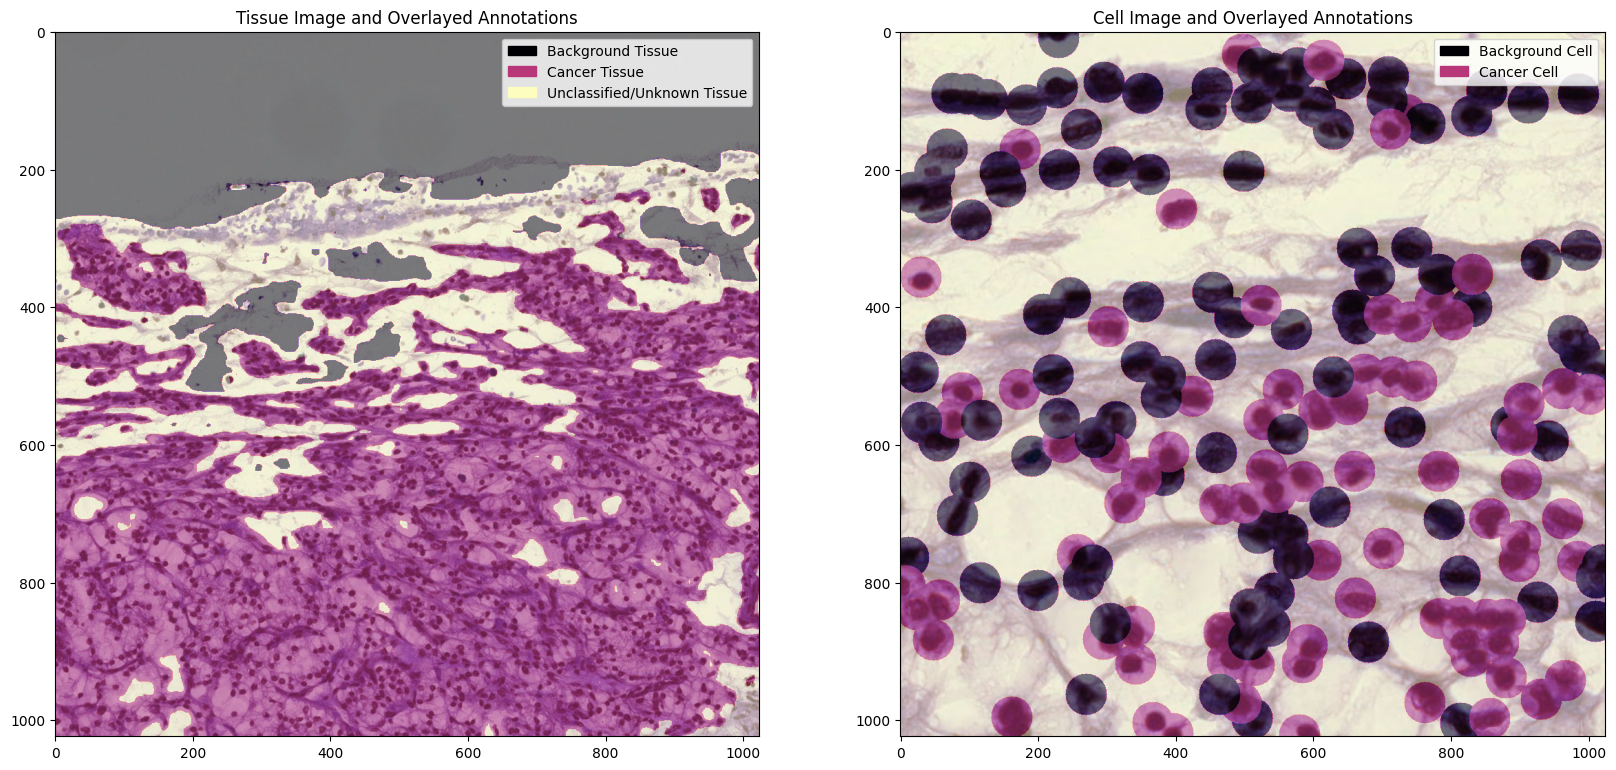

In [8]:
tissImg, cellImg, tissAnn, cellAnn = trainData[0]

# Shift pixel value for visualization
tissAnn = np.where(tissAnn == 2, 128, tissAnn) # 2 is cancer
tissAnn = np.where(tissAnn == 1, 0, tissAnn) # 1 is background
# 255 is unknown/unspecified
cmap = plt.cm.magma
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

# Plot the tissue image with overlayed annotations
im = ax[0].imshow(tissImg)
ax[0].imshow(tissAnn, alpha=0.5, cmap=cmap)
ax[0].set_title('Tissue Image and Overlayed Annotations')

background_patch = mpatches.Patch(color=cmap(0), label='Background Tissue')
cancer_patch = mpatches.Patch(color=cmap(128), label='Cancer Tissue')
unknown_patch = mpatches.Patch(color=cmap(255), label='Unclassified/Unknown Tissue')

ax[0].legend(handles=[background_patch, cancer_patch, unknown_patch], loc='upper right')

# Plot the cell image with overlayed annotations
cellAnn = np.where(cellAnn == 2, 128, cellAnn) # 2 is cancer
cellAnn = np.where(cellAnn == 0, 255, cellAnn) # 0 is unknown/unspecified
cellAnn = np.where(cellAnn == 1, 0, cellAnn) # 1 is background

ax[1].imshow(cellImg)
ax[1].imshow(cellAnn, alpha=0.5, cmap=cmap)
ax[1].set_title('Cell Image and Overlayed Annotations')

background_cell = mpatches.Patch(color=cmap(0), label='Background Cell')
cancer_cell = mpatches.Patch(color=cmap(128), label='Cancer Cell')
ax[1].legend(handles=[background_cell, cancer_cell], loc='upper right')

# Show the plot
plt.show()

## **NON-EQUIVARIANT CELL-SEGMENTATION**

In [30]:
from monai.losses import DiceCELoss, DiceLoss, MaskedDiceLoss
from monai.networks.utils import one_hot
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch.utils.data import DataLoader
from torch.optim import Adam
import os
import sys
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

path = os.getcwd()
par_path = os.path.abspath(os.pardir)
sys.path.append(par_path)

from model.unet import UnetVariant

Just checking that I can correctly pass input

In [31]:
out_channels = 1
model = UnetVariant(img_channels=3, out_channels=out_channels, in_channels=64)
x = torch.randn(1, 3, 256, 256)
y = model(x)

num_params = sum(p.numel() for p in UnetVariant.parameters(model))
print(num_params)

15669531


DataLoader with transforms

In [38]:
# we only apply augmentations for non-equivariant
trainTransforms = A.Compose([A.ElasticTransform(p=0.2),
                             A.HorizontalFlip(p=0.5),
                             A.RandomRotate90(p=0.5),
                             A.Normalize(mean = 0.0, std=1, always_apply=True),
                             ToTensorV2()])
valTestTransforms = A.Compose([A.Normalize(mean = 0.0, std=1, always_apply=True),
                               ToTensorV2()])   

trainData = OcelotDatasetLoaderV1(dataDir=dataDir, dataManifest=trainDataManifest, transforms=trainTransforms, trainMode='train', multiclass=True)
valData = OcelotDatasetLoaderV1(dataDir=dataDir, dataManifest=valDataManifest, transforms=valTestTransforms, trainMode='val', multiclass=True)

batch_size = 1
num_workers = 3

trainLoader = DataLoader(trainData, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valLoader = DataLoader(valData, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Found 400 images for train mode...
Found 137 images for val mode...


Hyperparameters, model, loss, optimizer...

In [39]:
lr = 0.001
n_epochs = 10
out_channels = 1
img_channels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optim = Adam(model.parameters(), lr=lr)
loss = DiceCELoss(sigmoid=True) if out_channels == 1 else DiceCELoss(softmax=True, to_onehot_y=True)
model = UnetVariant(img_channels=img_channels, out_channels=out_channels, in_channels=64).to(device)
print(f"Using {device}")

Using cpu


**DONT ACTUALLY TRAIN THE FOLLOWING IN THIS NOTEBOOK. THAT WOULD BE CRAZY. SEE trainEquivariant.py AND trainNonEquivariant.py INSTEAD!**

In [41]:
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(trainLoader):
        tissImg, cellImg, tissMask, cellMask = batch
        cellImg = cellImg.to(device)
        cellMask = cellMask.to(device).unsqueeze(1)

        optim.zero_grad()
        pred = model(cellImg)
        loss_val = loss(pred, cellMask)
        loss_val.backward()
        optim.step()

        train_loss += loss_val.item()

    train_loss /= len(trainLoader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in valLoader:
            tissImg, cellImg, tissMask, cellMask = batch
            cellImg = cellImg.to(device)
            cellMask = cellMask.to(device).unsqueeze(1)

            pred = model(cellImg)
            loss_val = loss(pred, cellMask)

            val_loss += loss_val.item()

    val_loss /= len(valLoader)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

  2%|▏         | 7/400 [01:32<1:26:06, 13.15s/it]


KeyboardInterrupt: 

## **EQUIVARIANT CELL-SEGMENTATION**